In [2]:
import pandas as pd
import os, json
import random
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
from PIL import Image
import zipfile
import cv2
import glob
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import normalize
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from sklearn.model_selection import train_test_split
import h5py

# AUTOENCODER

In [5]:
train_dir= '../input/preprocessed-batches/imgs27638.h5'
images = h5py.File(train_dir,'r')
a_group_key = list(images.keys())[0]

In [6]:
data = list(images[a_group_key])

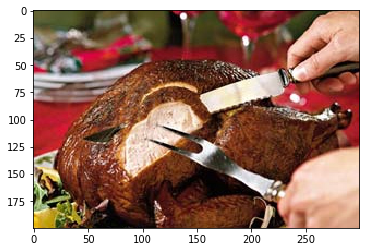

In [7]:
plt.imshow(data[5])

In [8]:
labels = pd.read_csv('../input/yummly-labels/flavours.csv',nrows=len(data))
labels = np.array(labels)
nan_labels = np.isnan(labels).any(axis=1)
print(nan_labels)

[ True False False ... False False  True]


In [9]:
#Remove nan rows from labels and images
new_labels = np.delete(labels,np.where(nan_labels==True),axis=0)

new_images= np.delete(data,np.where(nan_labels==True),axis=0)

In [10]:
#Transform the labels
from sklearn.preprocessing import OneHotEncoder,normalize
labels = pd.DataFrame(new_labels)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(labels)
labels = enc.transform(labels).toarray()

In [11]:
print(new_images.shape)
print(labels.shape)

(2839, 200, 300, 3)
(2839, 41)


In [12]:
pd.DataFrame(labels).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
def normalize(x):
    return (x.astype(float) - 128.0) / 128

In [138]:
#Reshape images
reshaped_imgs = []
for img in new_images:
    reshaped_imgs.append(normalize(cv2.resize(img,(128,128))))
reshaped_imgs = np.array(reshaped_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


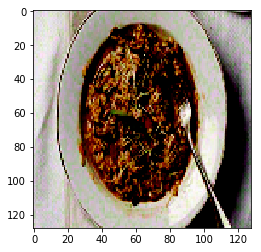

In [139]:
plt.imshow(reshaped_imgs[1])

In [140]:
reshaped_imgs.shape

(2839, 128, 128, 3)

# Autoencoder

In [141]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
model = Sequential()

#Encoder

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,128,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))

#Decoder

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

# Classification

In [142]:
# from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
# from keras.models import Model, Sequential
# from keras.optimizers import SGD

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(128,128,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(6, activation='sigmoid'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_100 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_101 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 32, 32, 32)        9248      
__________

In [144]:
#Make train/test sets for classification
#X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_imgs), new_labels,test_size=0.2)

#Make train/test sets for autoencoder
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_imgs), new_labels,test_size=0.2)


In [145]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,)

#Compute quantities for featurewise normalization
datagen.fit(X_train)

#Fit model 
model.fit_generator(datagen.flow(X_train, X_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=100)

Epoch 1/100
71/70 [==============================] - 13s 181ms/step - loss: 0.3576 - acc: 0.6957
Epoch 2/100
71/70 [==============================] - 8s 112ms/step - loss: 0.3104 - acc: 0.7556
Epoch 3/100
71/70 [==============================] - 8s 114ms/step - loss: 0.3047 - acc: 0.7591
Epoch 4/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2997 - acc: 0.7621
Epoch 5/100
71/70 [==============================] - 8s 115ms/step - loss: 0.2978 - acc: 0.7628
Epoch 6/100
71/70 [==============================] - 9s 128ms/step - loss: 0.2971 - acc: 0.7632
Epoch 7/100
71/70 [==============================] - 8s 115ms/step - loss: 0.2959 - acc: 0.7648
Epoch 8/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2959 - acc: 0.7651
Epoch 9/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2942 - acc: 0.7647
Epoch 10/100
71/70 [==============================] - 8s 113ms/step - loss: 0.2941 - acc: 0.7648
Epoch 11/100
71/70 [==================

71/70 [==============================] - 8s 115ms/step - loss: 0.2905 - acc: 0.7668
Epoch 86/100
71/70 [==============================] - 8s 118ms/step - loss: 0.2885 - acc: 0.7663
Epoch 87/100
71/70 [==============================] - 9s 127ms/step - loss: 0.2904 - acc: 0.7673
Epoch 88/100
71/70 [==============================] - 8s 115ms/step - loss: 0.2905 - acc: 0.7651
Epoch 89/100
71/70 [==============================] - 8s 116ms/step - loss: 0.2894 - acc: 0.7666
Epoch 90/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2894 - acc: 0.7659
Epoch 91/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2907 - acc: 0.7664
Epoch 92/100
71/70 [==============================] - 8s 114ms/step - loss: 0.2910 - acc: 0.7658
Epoch 93/100
71/70 [==============================] - 8s 120ms/step - loss: 0.2892 - acc: 0.7648
Epoch 94/100
71/70 [==============================] - 9s 124ms/step - loss: 0.2894 - acc: 0.7657
Epoch 95/100
71/70 [=======================

In [146]:
pred = model.predict(X_test)

Test Images


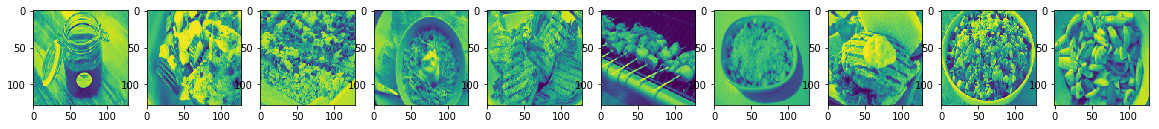

Reconstruction of Test Images


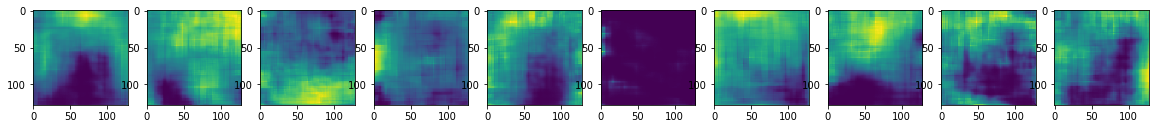

In [148]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, ..., 0])
    curr_lbl = y_test[i]
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0])  
plt.show()